In [4]:
import tensorflow as tf
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models
import cv2

In [3]:
!pip install opencv-python

   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   - -------------------------------------- 1.6/38.6 MB 33.8 MB/s eta 0:00:02
   -- ------------------------------------- 2.9/38.6 MB 36.8 MB/s eta 0:00:01
   ---- ----------------------------------- 4.5/38.6 MB 36.1 MB/s eta 0:00:01
   ------ --------------------------------- 6.0/38.6 MB 34.7 MB/s eta 0:00:01
   ------- -------------------------------- 7.5/38.6 MB 34.2 MB/s eta 0:00:01
   --------- ------------------------------ 9.0/38.6 MB 33.8 MB/s eta 0:00:01
   ---------- ----------------------------- 10.5/38.6 MB 34.4 MB/s eta 0:00:01
   ------------ --------------------------- 11.9/38.6 MB 32.8 MB/s eta 0:00:01
   ------------- -------------------------- 13.4/38.6 MB 32.7 MB/s eta 0:00:01
   --------------- ------------------------ 14.9/38.6 MB 32.7 MB/s eta 0:00:01
   ---------------- ----------------------- 16.4/38.6 MB 32.7 MB/s eta 0:00:01
   ------------------ --------------------- 17.9/38.6 MB 32.7 MB/s 

In [5]:
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [17]:
%cd G:/seefood/
print("Creating train data...")
prepare_data('food-101/meta/train.txt', 'food-101/images', 'train')

G:\seefood
Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee


In [16]:
%cd G:/seefood/

G:\seefood


In [18]:
%cd G:/seefood/
print("Creating test data...")
prepare_data('food-101/meta/test.txt', 'food-101/images', 'test')

G:\seefood
Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee



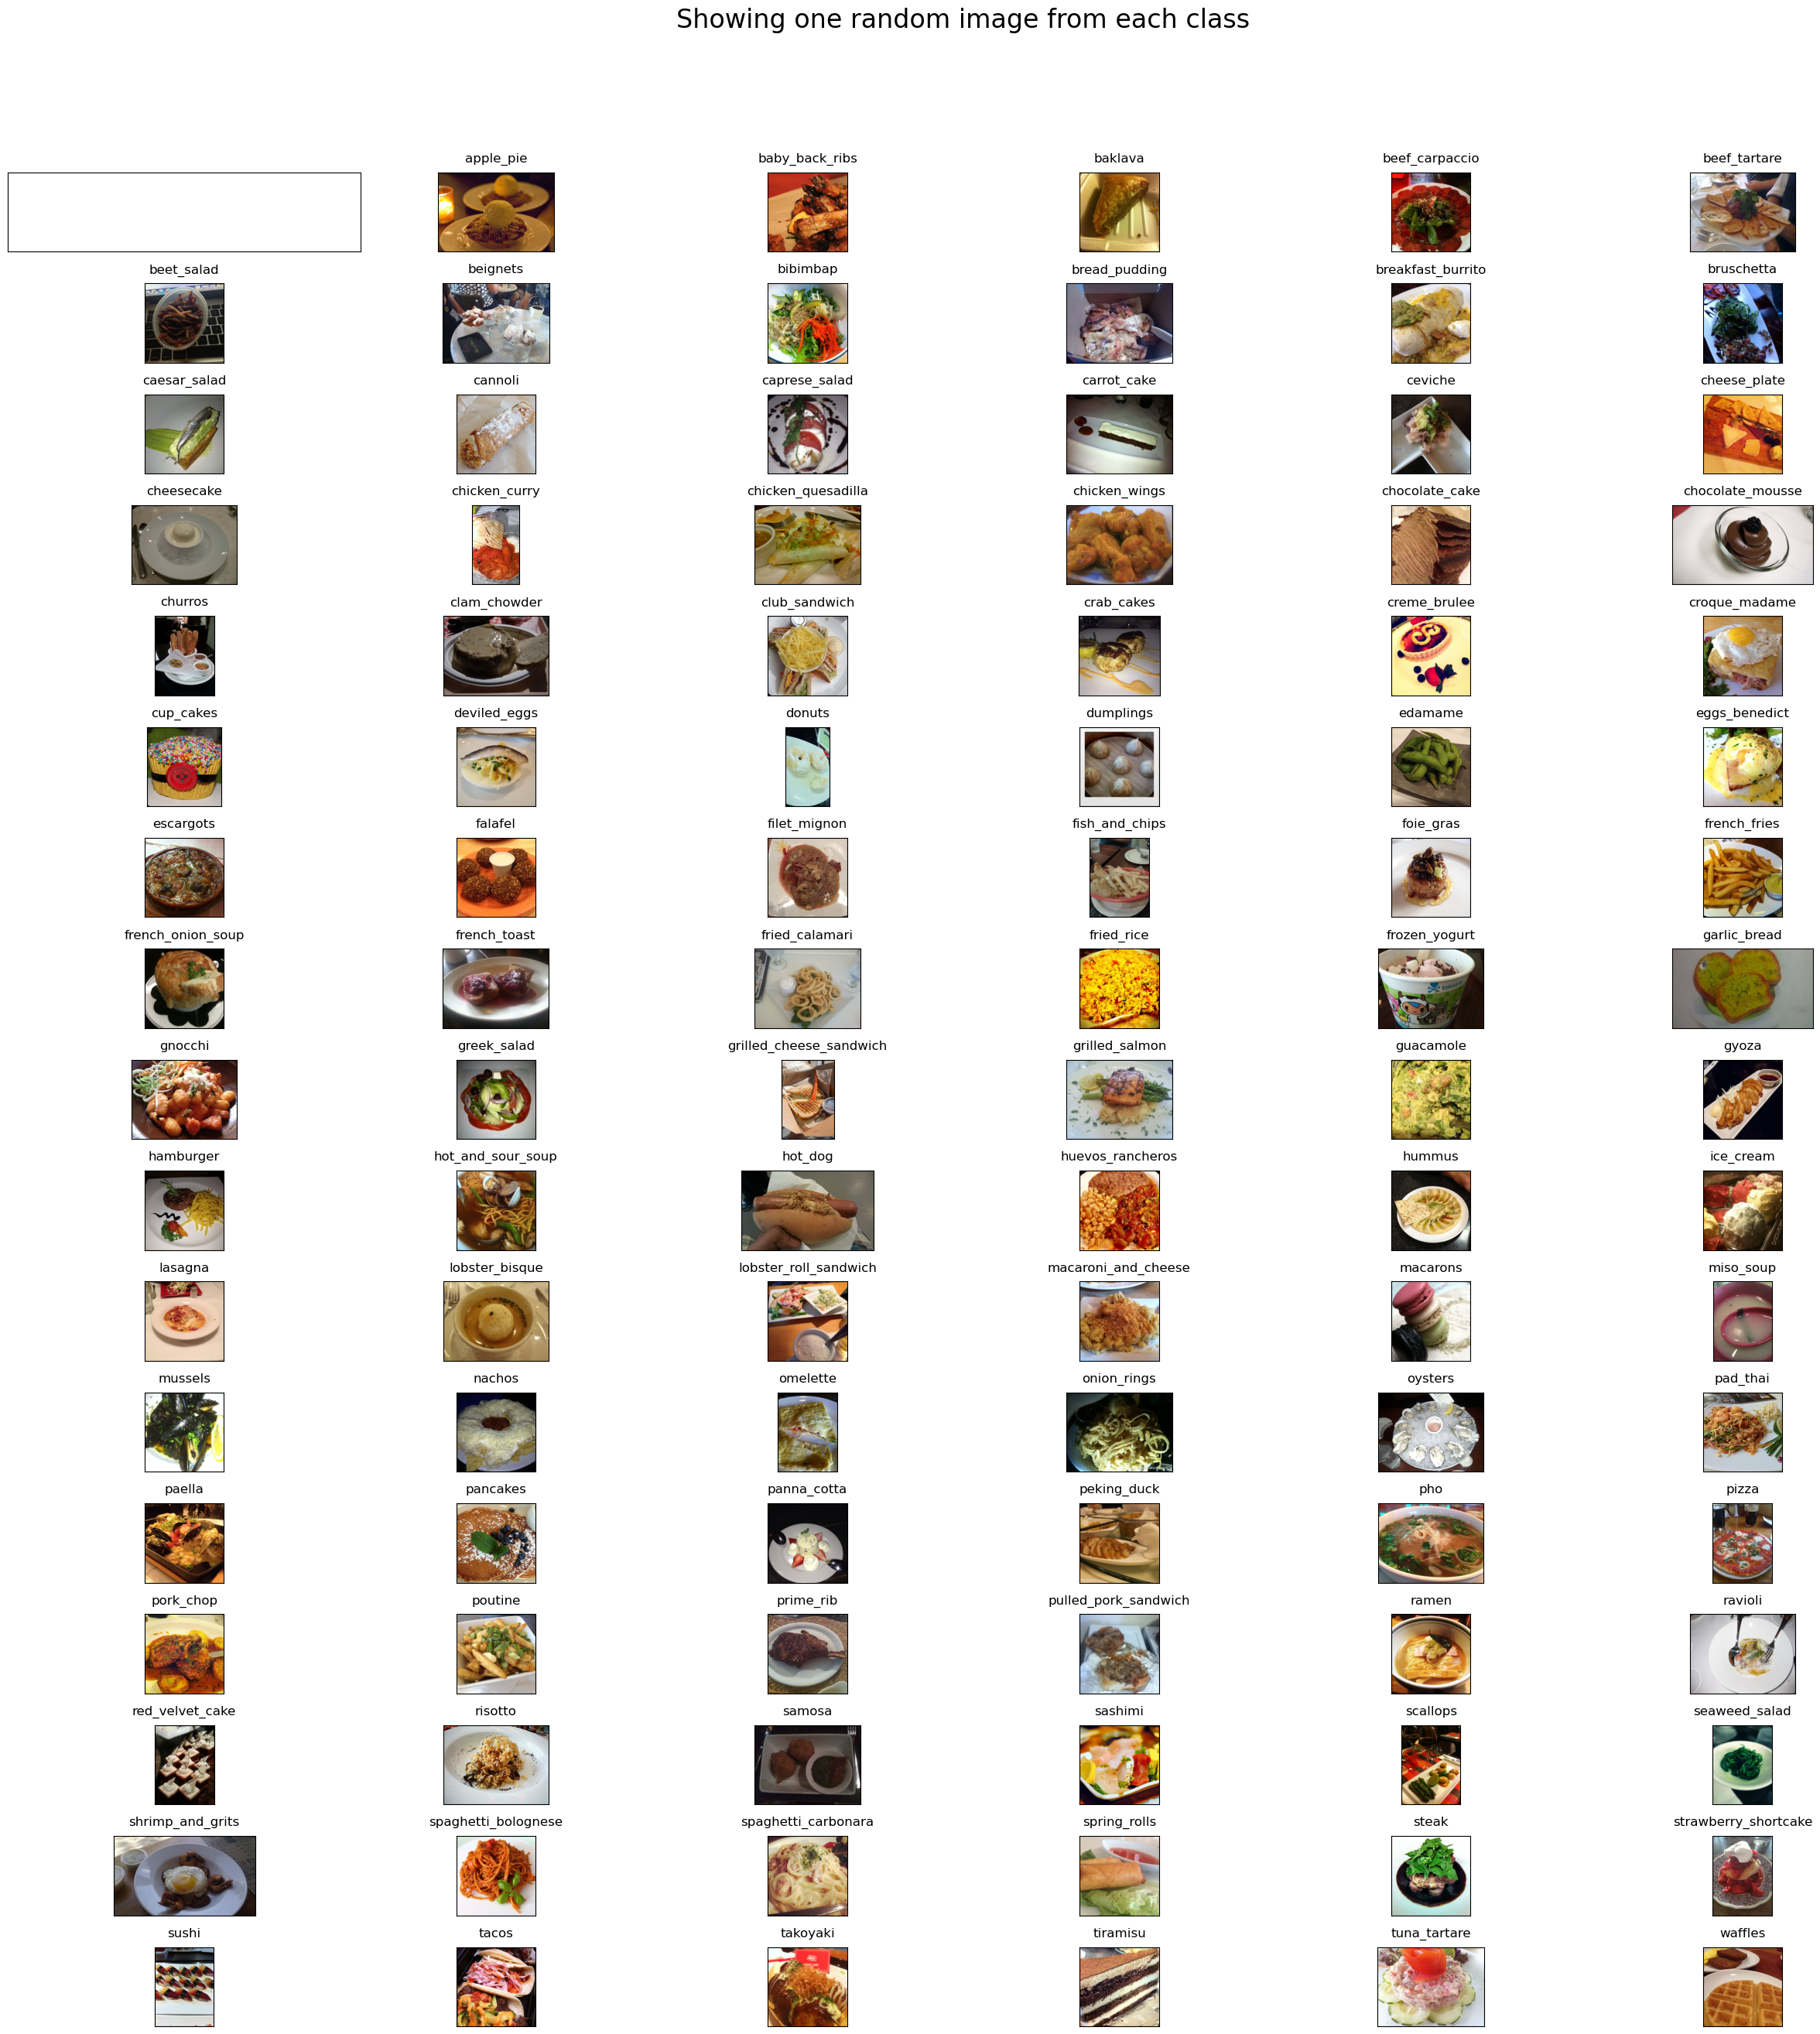

In [6]:
import matplotlib.pyplot as plt
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "food-101/images/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    if food_selected == '.DS_Store':
        continue
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()

In [9]:
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))

In [7]:
food_list = ['apple_pie','pizza','omelette']
src_train = 'train'
dest_train = 'train_mini'
src_test = 'test'
dest_test = 'test_mini'

In [10]:
print("Creating train data folder with new classes")
dataset_mini(food_list, src_train, dest_train)

Creating train data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into omelette


In [13]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into apple_pie


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'test\\apple_pie'

In [19]:
K.clear_session()
n_classes = 3
img_width, img_height = 299, 299
train_data_dir = 'train_mini'
validation_data_dir = 'test_mini'
nb_train_samples = 2250 #75750
nb_validation_samples = 750 #25250
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


inception = InceptionV3(weights='imagenet', include_top=False)
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(3,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model_3class.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history_3class.log')

history = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=30,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

model.save('model_trained_3class.hdf5')

Found 2250 images belonging to 3 classes.
Found 0 images belonging to 0 classes.

87910968/87910968 [==============================] - 3s 0us/step


C:\Users\John\AppData\Local\Temp\ipykernel_22220\644353269.py:44: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/30



140/140 [==============================] - ETA: 0s - loss: 0.6936 - accuracy: 0.7198WARNING:tensorflow:Can save best model only with val_loss available, skipping.


140/140 [==============================] - 216s 1s/step - loss: 0.6936 - accuracy: 0.7198
Epoch 2/30
140/140 [==============================] - ETA: 0s - loss: 0.4604 - accuracy: 0.8433WARNING:tensorflow:Can save best model only with val_loss available, skipping.


140/140 [==============================] - 212s 2s/step - loss: 0.4604 - accuracy: 0.8433
Epoch 3/30
140/140 [==============================] - ETA: 0s - loss: 0.3966 - accuracy: 0.8603WARNING:tensorflow:Can save best model only with val_loss available, skipping.


140/140 [==============================] - 207s 1s/step - loss: 0.3966 - accuracy: 0.8603
Epoch 4/30
140/140 [==============================] - ETA: 0s - loss: 0.3017 - accuracy: 0.8975WARNING:tensorflow:Can save best model only with val_loss available, skipping.


140/140 [==============================] - 206s 1s/step - loss: 0.3017 - accuracy: 0.8975
Epoch 5/30
140/140 [==============================] - ETA: 0s - loss: 0.2742 - accuracy: 0.9064WARNING:tensorflow:Can save best model only with val_loss available, skipping.


140/140 [==============================] - 207s 1s/step - loss: 0.2742 - accuracy: 0.9064
Epoch 6/30
140/140 [==============================] - ETA: 0s - loss: 0.2721 - accuracy: 0.9020WARNING:tensorflow:Can save best model only with val_loss available, skipping.


140/140 [==============================] - 210s 1s/step - loss: 0.2721 - accuracy: 0.9020
Epoch 7/30
140/140 [==============================] - ETA: 0s - loss: 0.2379 - accuracy: 0.9217WARNING:tensorflow:Can save best model only with val_loss available, skipping.


140/140 [==============================] - 211s 2s/step - loss: 0.2379 - accuracy: 0.9217
Epoch 8/30
140/140 [==============================] - ETA: 0s - loss: 0.2136 - accuracy: 0.9355WARNING:tensorflow:Can save best model only with val_loss available, skipping.


140/140 [==============================] - 211s 2s/step - loss: 0.2136 - accuracy: 0.9355
Epoch 9/30
140/140 [==============================] - ETA: 0s - loss: 0.1948 - accuracy: 0.9396WARNING:tensorflow:Can save best model only with val_loss available, skipping.


140/140 [==============================] - 208s 1s/step - loss: 0.1948 - accuracy: 0.9396
Epoch 10/30
140/140 [==============================] - ETA: 0s - loss: 0.1705 - accuracy: 0.9423WARNING:tensorflow:Can save best model only with val_loss available, skipping.


140/140 [==============================] - 207s 1s/step - loss: 0.1705 - accuracy: 0.9423
Epoch 11/30
140/140 [==============================] - ETA: 0s - loss: 0.1753 - accuracy: 0.9467WARNING:tensorflow:Can save best model only with val_loss available, skipping.


140/140 [==============================] - 212s 2s/step - loss: 0.1753 - accuracy: 0.9467
Epoch 12/30
140/140 [==============================] - ETA: 0s - loss: 0.1417 - accuracy: 0.9584WARNING:tensorflow:Can save best model only with val_loss available, skipping.


140/140 [==============================] - 209s 1s/step - loss: 0.1417 - accuracy: 0.9584
Epoch 13/30
140/140 [==============================] - ETA: 0s - loss: 0.1027 - accuracy: 0.9745WARNING:tensorflow:Can save best model only with val_loss available, skipping.


140/140 [==============================] - 206s 1s/step - loss: 0.1027 - accuracy: 0.9745
Epoch 14/30
140/140 [==============================] - ETA: 0s - loss: 0.0908 - accuracy: 0.9722WARNING:tensorflow:Can save best model only with val_loss available, skipping.


140/140 [==============================] - 206s 1s/step - loss: 0.0908 - accuracy: 0.9722
Epoch 15/30
140/140 [==============================] - ETA: 0s - loss: 0.1256 - accuracy: 0.9646WARNING:tensorflow:Can save best model only with val_loss available, skipping.


140/140 [==============================] - 209s 1s/step - loss: 0.1256 - accuracy: 0.9646
Epoch 16/30
140/140 [==============================] - ETA: 0s - loss: 0.1029 - accuracy: 0.9718WARNING:tensorflow:Can save best model only with val_loss available, skipping.


140/140 [==============================] - 214s 2s/step - loss: 0.1029 - accuracy: 0.9718
Epoch 17/30
140/140 [==============================] - ETA: 0s - loss: 0.1027 - accuracy: 0.9669WARNING:tensorflow:Can save best model only with val_loss available, skipping.


140/140 [==============================] - 209s 1s/step - loss: 0.1027 - accuracy: 0.9669
Epoch 18/30
140/140 [==============================] - ETA: 0s - loss: 0.0654 - accuracy: 0.9812WARNING:tensorflow:Can save best model only with val_loss available, skipping.


140/140 [==============================] - 212s 2s/step - loss: 0.0654 - accuracy: 0.9812
Epoch 19/30
140/140 [==============================] - ETA: 0s - loss: 0.1103 - accuracy: 0.9655WARNING:tensorflow:Can save best model only with val_loss available, skipping.


140/140 [==============================] - 210s 1s/step - loss: 0.1103 - accuracy: 0.9655
Epoch 20/30
140/140 [==============================] - ETA: 0s - loss: 0.0984 - accuracy: 0.9687WARNING:tensorflow:Can save best model only with val_loss available, skipping.


140/140 [==============================] - 207s 1s/step - loss: 0.0984 - accuracy: 0.9687
Epoch 21/30
140/140 [==============================] - ETA: 0s - loss: 0.0686 - accuracy: 0.9816WARNING:tensorflow:Can save best model only with val_loss available, skipping.


140/140 [==============================] - 222s 2s/step - loss: 0.0686 - accuracy: 0.9816
Epoch 22/30
140/140 [==============================] - ETA: 0s - loss: 0.0811 - accuracy: 0.9731WARNING:tensorflow:Can save best model only with val_loss available, skipping.


140/140 [==============================] - 218s 2s/step - loss: 0.0811 - accuracy: 0.9731
Epoch 23/30
140/140 [==============================] - ETA: 0s - loss: 0.0618 - accuracy: 0.9839WARNING:tensorflow:Can save best model only with val_loss available, skipping.


140/140 [==============================] - 213s 2s/step - loss: 0.0618 - accuracy: 0.9839
Epoch 24/30
140/140 [==============================] - ETA: 0s - loss: 0.0774 - accuracy: 0.9758WARNING:tensorflow:Can save best model only with val_loss available, skipping.


140/140 [==============================] - 220s 2s/step - loss: 0.0774 - accuracy: 0.9758
Epoch 25/30
140/140 [==============================] - ETA: 0s - loss: 0.0673 - accuracy: 0.9812WARNING:tensorflow:Can save best model only with val_loss available, skipping.


140/140 [==============================] - 226s 2s/step - loss: 0.0673 - accuracy: 0.9812
Epoch 26/30
140/140 [==============================] - ETA: 0s - loss: 0.0725 - accuracy: 0.9767WARNING:tensorflow:Can save best model only with val_loss available, skipping.


140/140 [==============================] - 219s 2s/step - loss: 0.0725 - accuracy: 0.9767
Epoch 27/30
140/140 [==============================] - ETA: 0s - loss: 0.0770 - accuracy: 0.9758WARNING:tensorflow:Can save best model only with val_loss available, skipping.


140/140 [==============================] - 219s 2s/step - loss: 0.0770 - accuracy: 0.9758
Epoch 28/30
140/140 [==============================] - ETA: 0s - loss: 0.0875 - accuracy: 0.9736WARNING:tensorflow:Can save best model only with val_loss available, skipping.


140/140 [==============================] - 217s 2s/step - loss: 0.0875 - accuracy: 0.9736
Epoch 29/30
140/140 [==============================] - ETA: 0s - loss: 0.0389 - accuracy: 0.9870WARNING:tensorflow:Can save best model only with val_loss available, skipping.


140/140 [==============================] - 221s 2s/step - loss: 0.0389 - accuracy: 0.9870
Epoch 30/30
140/140 [==============================] - ETA: 0s - loss: 0.0845 - accuracy: 0.9767WARNING:tensorflow:Can save best model only with val_loss available, skipping.


140/140 [==============================] - 222s 2s/step - loss: 0.0845 - accuracy: 0.9767


c:\anaconda3\envs\py39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
